# Boston 주택 가격 예측 모델

## 데이터 Feature 정리

|feature|설명|
|--|--|
|CRIM|자치시별 1인당 범죄율|
|ZN|25,000 평방비트를 초과하는 거주지역의 비율|
|INDUS|비소매상업지역이 점유하고 있는 토지의 비율|
|CHAS|찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)|
|NOX|10ppm 당 농축 일산화질소|
|RM|주택 1 가구당 평균 방의 개수|
|AGE|1940년 이전에 건축된 소유주택의 비율|
|DIS|5개의 보스턴 직업센터까지의 접근성 지수|
|RAD|방사형 도로까지의 접근성 지수|
|TAX|10,000 달러당 재산세율|
|PTRATIO|자치시(town)별 학생/교사 비율|
|B|$1000(B_k - 0.63)^2$, 여기서 $B_k$는 자치시별 흑인의 비율을 말함|
|LSTAT|모집단의 하위계층의비율(%)|
|MEDV|본인 소유의 주택가격(중앙값)(단위:$1,000)|

## 초기 환경설정

In [1]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## 데이터 불러오기

In [2]:
# keras.datasets 안에 boston_housing 데이터셋을 로드합니다.
from tensorflow.keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# 데이터셋의 크기를 확인합니다.
print(len(train_data))
print(len(test_data))

404
102


## 데이터 표준화 작업

In [3]:
# 문제 1-1: 데이터셋의 전처리를 위해 표준화 작업을 수행합니다.
# 먼저 입력 데이터의 각 특성의 평균을 뺍니다.
mean = train_data.mean(axis=0)
train_data = train_data - mean

# 평균을 뺀 입력 데이터에서 표준편차를 나눕니다.
# 데이터 특성의 중앙이 0에 가깝게 만들고, 표준편차가 1이 되게 만듭니다.
std = train_data.std(axis=0)
train_data = train_data / std

# 테스트 데이터셋도 마찬가지로 평균을 빼고, 표준편차로 나눕니다.
test_data = test_data - mean
test_data = test_data / std

## 모델 구성 및 컴파일

In [12]:
# 문제 1-2: 주택 가격 예측을 위한 딥러닝 모델 구성 및 컴파일합니다.
# input_shape은 (train_data.shape[1], )으로 구성합니다.
# 회귀(예측)을 위한 모델이므로 loss를 mse, metrics를 mae로 사용합니다.
from tensorflow.keras.utils import plot_model
model = models.Sequential()
model.add(layers.Input(shape=(train_data.shape[1], )))
model.add(layers.Dense(13, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
plot_model(model, to_file='model_shapes.png', show_shapes=True)
model.summary()

model.compile(loss='mse', metrics=['mae'],optimizer='adam')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_21 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 5,303
Trainable params: 5,303
Non-trainable params: 0
_________________________________________________________________


## 모델 학습 및 시각화

Epoch 1/50
21/21 [==============================] - 1s 5ms/step - loss: 539.7436 - mae: 21.3667 - val_loss: 560.2946 - val_mae: 21.8889

Epoch 00001: val_loss improved from inf to 560.29462, saving model to best_model.h5
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 435.7057 - mae: 18.8643 - val_loss: 397.7821 - val_mae: 18.0276

Epoch 00002: val_loss improved from 560.29462 to 397.78210, saving model to best_model.h5
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 245.3478 - mae: 13.1749 - val_loss: 162.8559 - val_mae: 9.9453

Epoch 00003: val_loss improved from 397.78210 to 162.85585, saving model to best_model.h5
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 105.1596 - mae: 7.9480 - val_loss: 96.2116 - val_mae: 7.8023

Epoch 00004: val_loss improved from 162.85585 to 96.21159, saving model to best_model.h5
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 76.6523 - mae: 6.7976 - val_los

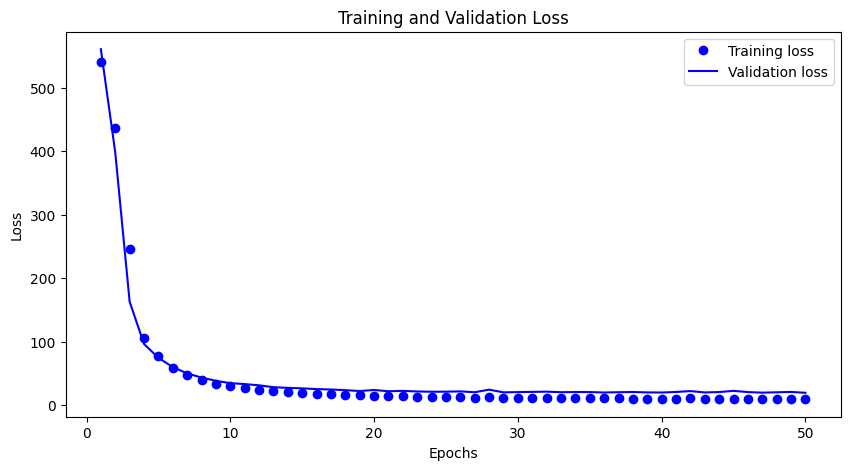

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint: 에포크마다 모델을 저장하는 콜백
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# EarlyStopping: 성능 향상이 멈출 경우 훈련을 조기 종료하는 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# 모델 훈련
history = model.fit(train_data, train_labels, epochs=50, batch_size=16,
                    validation_split=0.2, callbacks=[checkpoint, early_stopping], verbose=1)

# 훈련 과정 시각화
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)


## Train_data VS Val_data loss, MAE 시각화

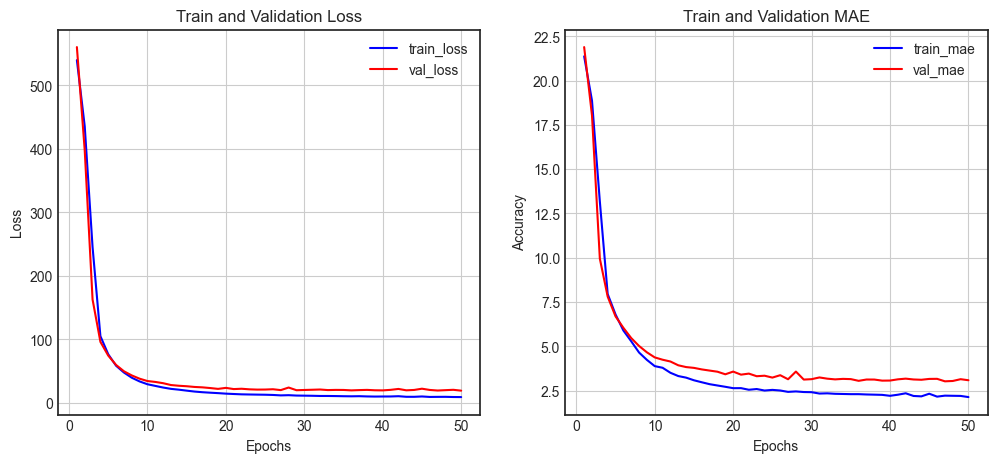

In [6]:
# 모델 학습 히스토리에서 loss, val_loss, mae, val_mae를 차트로 보여줍니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')
ax2.plot(epochs, val_mae, 'r-', label='val_mae')
ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [7]:
# 테스트 데이터셋으로 모델 평가
test_loss, test_mae = model.evaluate(test_data, test_labels)

print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')


4/4 [==============================] - 0s 1ms/step - loss: 23.6480 - mae: 3.0845
Test Loss: 23.64800262451172
Test MAE: 3.084458827972412


## 회고

분류만 한참을 했었는데, 회귀를 할때는 마지막 Fully_connectd layer에서 1개로 빼고 활성화 함수가 안들어간다는 것을 처음 알게 되었다.
의외로 loss 값이 적고 MAE 값이 적게나와서 좋은 딥러닝이 된 것 같았다.
하지만 이건 엄밀히말해서 비슷한 데이터 값인 것이고, 나중에 완전 다른 데이터가 나왔을 때도 고려를 해봐야 할 것 같다.
저번 메인 퀘스트때 시각화를 안해서 아쉽다는 평을 받았는데 여기서 시각화를 한번 더 배우는 것 같아서 다행이다.

- **K**
    -  동영상에 나오는 plot_model을 보고 레이어층 구현을 바로 함
- **P**
    - 시각화 부분을 봐도 어려웠음
- **T**
    - 시각화 부분 코드를 이해하려고 노력